Working dir: /home/vladimir/VehicleRecognition
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] f

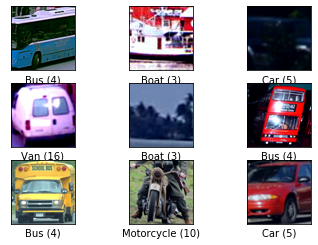

In [2]:
import argparse
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from time import localtime, strftime
import os
import copy
import sys
sys.path.append('./part2/')

from dataset import get_train_valid_loader
from utils import workdir_copy

input_size = 224
train_data_dir = '/home/nvme/data/openimg/train/train'
# checks
pwd = os.getcwd()
assert os.getcwd().endswith('VehicleRecognition')
assert os.path.exists('./part2/experiments/')
print(f'Working dir: {pwd}')

# save the experiment time
start_time = strftime("%y%m%d%H%M%S", localtime())

# define the paths
save_pred_path = None
save_pred_path = f'./part2/experiments/{start_time}.csv'
save_best_model_path = f'/home/hdd/logs/openimg/{start_time}/best_model.pt'

# backup the working directiory
workdir_copy(pwd, os.path.split(save_best_model_path)[0])

# Detect if we have a GPU available
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# valid ratio
valid_size = 0.25
# learning rate
lr = 1e-3

# fix the random seed
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# paths to dataset
# data_dir = '/home/nvme/data/openimg/hymenoptera_data/'
train_data_dir = '/home/nvme/data/openimg/train/train/'
test_data_dir = '/home/nvme/data/openimg/test/testset/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_32x48d_wsl'
# 'resnext101_32x32d_wsl'
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = len(os.listdir(train_data_dir))

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# num of workers for data loading
num_workers = 16

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'a': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_loader, valid_loader = get_train_valid_loader(
    train_data_dir, batch_size, data_transforms, seed, valid_size=valid_size,
    shuffle=True, show_sample=True, num_workers=num_workers, pin_memory=False)

valid_loader.dataset.transforms = data_transforms['a']


In [3]:
valid_loader.dataset.transforms

Compose(
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)